In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "LettuceVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 206 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Healthy', 'Infected']

In [5]:
len(dataset)

7

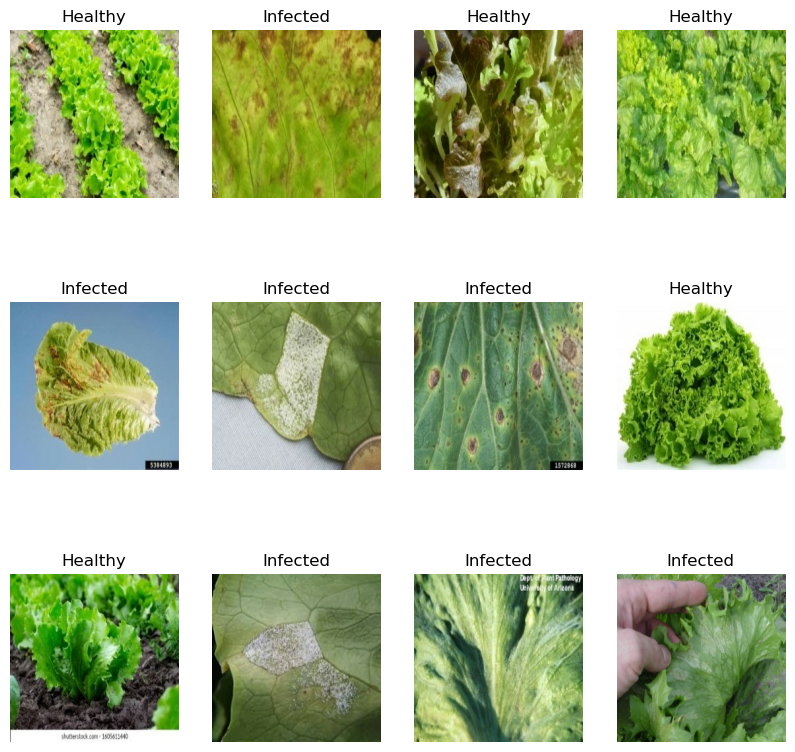

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [7]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

4

In [10]:
len(val_ds)

1

In [11]:
len(test_ds)

2

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
4/4 [==============================] - 9s 542ms/step - loss: 0.7003 - accuracy: 0.4766 - val_loss: 0.7023 - val_accuracy: 0.4286
Epoch 2/50
4/4 [==============================] - 2s 418ms/step - loss: 0.6883 - accuracy: 0.5078 - val_loss: 0.6949 - val_accuracy: 0.4286
Epoch 3/50
4/4 [==============================] - 2s 433ms/step - loss: 0.6888 - accuracy: 0.5078 - val_loss: 0.6936 - val_accuracy: 0.4286
Epoch 4/50
4/4 [==============================] - 2s 383ms/step - loss: 0.6830 - accuracy: 0.5078 - val_loss: 0.6832 - val_accuracy: 0.4286
Epoch 5/50
4/4 [==============================] - 2s 417ms/step - loss: 0.6716 - accuracy: 0.5234 - val_loss: 0.6721 - val_accuracy: 0.4286
Epoch 6/50
4/4 [==============================] - 2s 374ms/step - loss: 0.6533 - accuracy: 0.5391 - val_loss: 0.6589 - val_accuracy: 0.5000
Epoch 7/50
4/4 [==============================] - 2s 394ms/step - loss: 0.6290 - accuracy: 0.6250 - val_loss: 0.6358 - val_accuracy: 0.7143
Epoch 8/50
4/4 [====

In [19]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 0s 60ms/step - loss: 0.1621 - accuracy: 0.9783


In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 4}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
len(history.history['loss'])

50

In [24]:
history.history['loss'][:5]

[0.7002895474433899,
 0.688298225402832,
 0.6888487935066223,
 0.6830334067344666,
 0.6716196537017822]

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

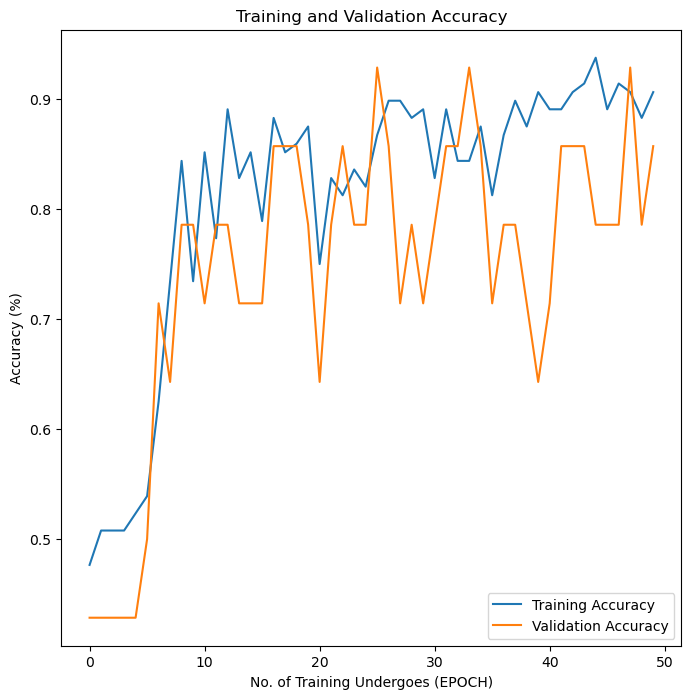

In [38]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("No. of Training Undergoes (EPOCH)")
plt.ylabel("Accuracy (%)")
plt.show()

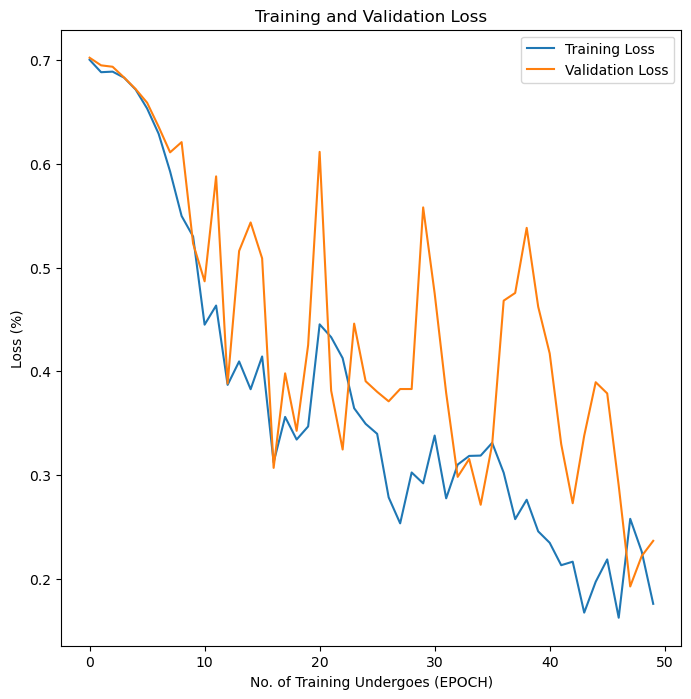

In [37]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("No. of Training Undergoes (EPOCH)")
plt.ylabel("Loss (%)")
plt.show()

first image to predict
actual label: Healthy
1/1 [==============================] - 0s 363ms/step
predicted label: Healthy


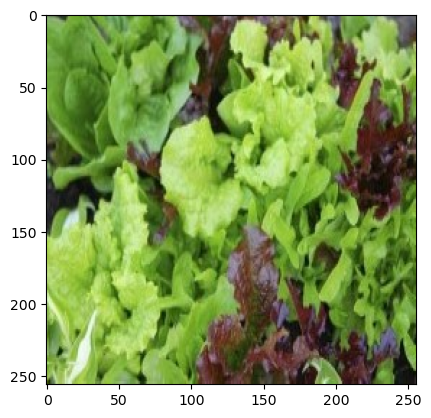

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


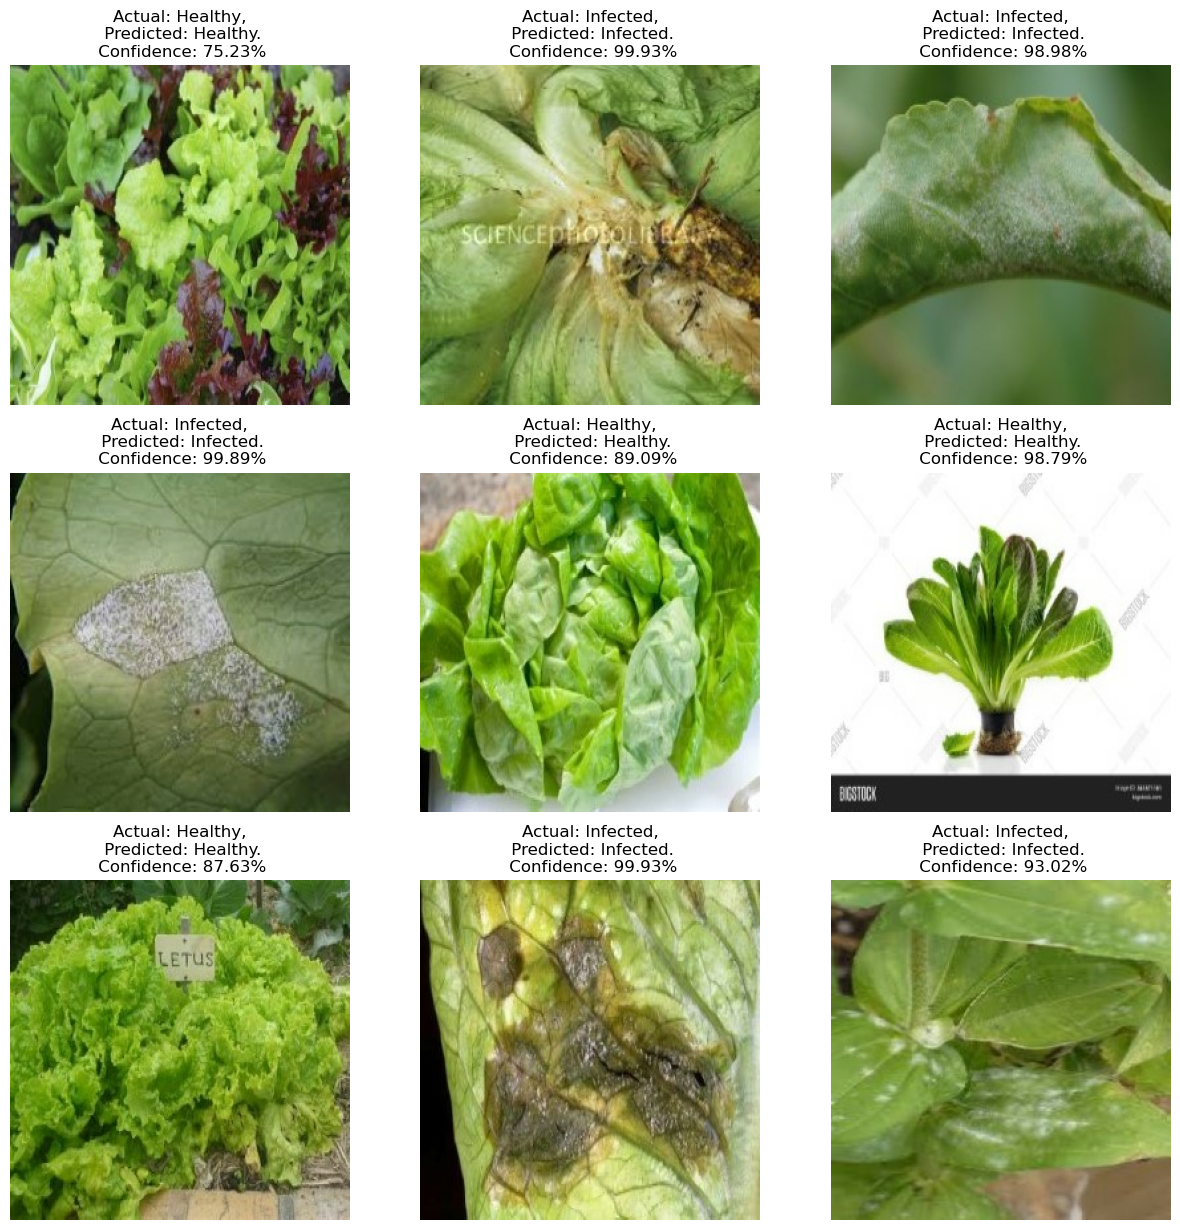

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
model_version=6
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/6\assets


INFO:tensorflow:Assets written to: models/6\assets


In [34]:
model.save(f"models/{model_version}/lettuce_prediction_model.h5")

In [94]:
from tensorflow.keras.models import load_model

# Load the pre-trained model
model_dir = 'C:\\Users\\alexc\\OneDrive - Universiti Teknologi PETRONAS\\Uni Stuff\\Final Year Sem3\\FYP2\\models\\5\\lettuce_prediction_model.h5' 
model_5 = load_model(model_dir)

1/1 [==============================] - 0s 151ms/step


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

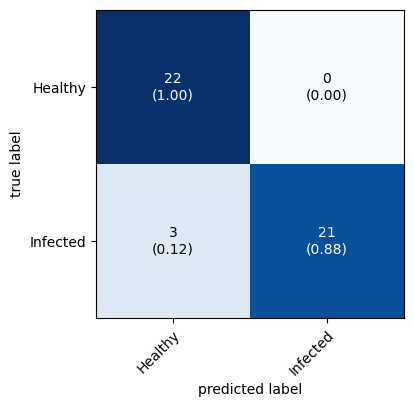

In [97]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

pred = []
true = []
for images, labels in test_ds:
    predictions = model_5.predict(images)
    pred.extend(np.argmax(predictions, axis=1))
    true.extend(labels.numpy())

mat = confusion_matrix(true, pred)
plot_confusion_matrix(conf_mat=mat, figsize=(4,4), class_names=class_names, show_normed=True)
# Compute confusion matrix
#cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
#plt.figure(figsize=(8, 8))
#plt.imshow(cm, cmap=plt.cm.Blues)
#plt.xlabel("Predicted labels")
#plt.ylabel("True labels")
#plt.xticks(range(len(class_names)), class_names, rotation=45)
#plt.yticks(range(len(class_names)), class_names)
#plt.colorbar()
#plt.show()

In [101]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)


0.9347826086956522